# Assignment 1: Car Plate Recognition

After test-running the code in the original notebook (`ocr.ipynb`, the results can be seen there), with some modifications to work with our dataset (I never got `trdg` to work on my computer and decided to go straight to the car plate data), I copied the relevant code to this notebook to keep track of exactly what parts of the original code I was using. That means that this notebook does not require any additional code files to run. This is where I trained my models properly (or at least more properly than in the original notebook), for 100 epochs each, and discuss the results. I have done my best to clearly state which parts are borrowed and what is my own code. 

Actually, I found the original code unnecessarily complex and hard to follow, with less documentation than I would have liked. It was a bit frustrating at times to have to search through a bunch of files to find which function was calling what other functions where and figure out where to disconnect them and fit my own code in without just breaking everything. 

In [1]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from textdistance import levenshtein as lev

from tqdm.auto import tqdm
from IPython import embed
import matplotlib.pyplot as plt
from collections import Counter

### Preparations
The dataset and collate function defined below are what I used in the original notebook to be able to use the car plate dataset with their model. They are based on my own code. The CTC loss and the label converter, however, are borrowed from the tutorial.

In [2]:
# The following is my own code:

class CarPlateDataset(Dataset):
    def __init__(self, image_dir, annotation_dir):
        super(CarPlateDataset, self).__init__()
        self.images = os.listdir(image_dir)
        self.annotation_files = os.listdir(annotation_dir)
        assert len(self.images) == len(self.annotation_files), 'error: inequal number of images and annotations'
        self.n_samples = len(self.images)
        imagepaths = lambda x: os.path.join(image_dir, x)
        self.imagepaths = list(map(imagepaths, self.images))
        annotationpaths = lambda x: os.path.join(annotation_dir, x)
        self.annotationpaths = list(map(annotationpaths, self.annotation_files))

        transform_list =  [transforms.Grayscale(1),
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = MyCollator()

    def get_label(xml_path):
        xml = pd.read_xml(xml_path)
        label = ''.join([char for char in xml['name'] if char is not None])
        return label

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        assert idx <= len(self), 'index range error'
        image = Image.open(self.imagepaths[idx])
        image = self.transform(image)
        xml = xml = pd.read_xml(self.annotationpaths[idx])
        label = ''.join([char for char in xml['name'] if char is not None])
        #label = get_label(self.annotationpaths[idx])
        item = {'img': image, 'idx':idx, 'label':label}
        return item

In [3]:
# The following is my own code:

class MyCollator(object):
    def __call__(self, batch):
        # Padding all images in a batch to the same height and width:
        indices = [item['idx'] for item in batch]
        maxheight = max([item['img'].shape[1] for item in batch])
        maxwidth = max([item['img'].shape[2] for item in batch])
        images = torch.ones([len(batch), 1, maxheight, maxwidth], dtype=torch.float32)
        for idx, item in enumerate(batch):
            img = item['img']
            try: 
                images[idx, :, 0:img.shape[1], 0:img.shape[2]] = img
            except:
                print(images.shape)
        item = {'img': images, 'idx':indices}
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        return item

In [4]:
# This is borrowed straight from the tutorial (src/utils/utils.py):

class OCRLabelConverter(object):
    """Convert between str and label.

    NOTE:
        Insert `blank` to the alphabet for CTC.

    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=False):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1
        self.dict[''] = 0
    def encode(self, text):
        """Support batch or single str.

        Args:
            text (str or list of str): texts to convert.

        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        '''
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))
        '''
        length = []
        result = []
        for item in text:
            # item = item.decode('utf-8', 'strict')
            length.append(len(item))
            for char in item:
                if char in self.dict:
                    index = self.dict[char]
                else:
                    print(f'Label converter: character {char} not in alphabet!')
                    index = 0
                result.append(index)

        text = result
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.

        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.

        Raises:
            AssertionError: when the texts and its length does not match.

        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(),
                                                                                                         length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(
                t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

In [7]:
# The following is borrowed straight from the tutorial:

class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

### Models
I used two different models for my experiments. While they are both largely based on the original model from the tutorial, the second one has some extra features to improve it.

#### First model:

In [5]:
# This is the model from the tutorial (with minimal changes to work with my dataset and code layout)
# (superfluous code from the original tutorial is commented out but still left in the script)

class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class TutorialModel(nn.Module):

    def __init__(self, n_hidden, n_classes, leakyRelu=False): # changed to take the specific values needed as args instead of a whole
                                                              # dict of options (because it made the original code hard to follow)
        super(TutorialModel, self).__init__()

        # assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = 1 if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(n_hidden*2, n_hidden, n_hidden),
            BidirectionalLSTM(n_hidden, n_hidden, n_classes))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        # assert h == 1, "the height of conv must be 1"
        # conv = conv.squeeze(2)
        conv = conv.view(b,c,h*w)
        conv = conv.permute(2, 0, 1)  # [w, b, h]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output

#### Second model:
The changes I made in this model were mainly in response to the results of the first model. The main thing I noticed was that even though the loss went down during training, the accuracy on both training and validation data remained zero for a very long time. After inspecting some model outputs (see below) it became clear that this was because the model only ever predicted the empty string. I found this very problem discussed [here](https://discuss.pytorch.org/t/ctcloss-predicts-blanks/66928), and from what i understand it seems like this is a pretty common issue with CTC loss, and that they need many epochs to stop predicting blanks. I also took someones advice (from that same discussion) to increase the number of recurrent layers. As I understood it, this is a case of underfitting, where it is basically choosing the easiest solution instead of finding the more complex patterns. I think that increasing the complexity of the character prediction part of the model (ie the lstm) is a way to help it find those more complex patterns (is that correct?). And then of course it is also a matter of training time. At training time, I also increased the learning rate for this model from 0.001 to 0.01, to see if that could help shock it out of the local minimum both models seemed to get stuck in.

In [6]:
# This model is based on the one in the tutorial, but it has an
# added linear layer between the cnn and the lstm, and more lstm layers. 

class ModifiedTutorialModel(nn.Module):

    def __init__(self, n_hidden, n_classes, leakyRelu=False):
        super(ModifiedTutorialModel, self).__init__()

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = 1 if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.linear1 = nn.Linear(n_hidden*2, n_hidden)
        self.lstm = nn.LSTM(n_hidden, n_hidden, num_layers=4, bidirectional=True)
        self.linear2 = nn.Linear(n_hidden*2, n_classes)


    def forward(self, input):
        # conv layers
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        conv = conv.view(b,c,h*w)
        conv = conv.permute(2, 0, 1)  # [w, b, h]
        output = self.linear1(conv)
        # lstm layer
        self.lstm.flatten_parameters()
        output, _ = self.lstm(output)
        T, b, h = output.size()
        t_rec = output.view(T * b, h)
        output = self.linear2(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        output = output.transpose(1,0) #Tbh to bth
        return output

In [8]:
# More or less borrowed from tutorial:
def char_accuracy(pair):
    prediction, truth = pair
    edit_dist = lev.distance(prediction, truth)
    gt_length = len(truth)
    fraction = 0
    if gt_length != 0:
        fraction = edit_dist / gt_length

    percent = fraction * 100
    if 100.0 - percent < 0:
        return 0.0
    else:
        return 100.0 - percent

# Mainly my own code:
def train_ocr(options):
    device = options['device']
    model = options['model']
    loss_fn = options['loss_fn'].to(device)
    optimizer = options['optim'](model.parameters(), lr=options['lr'])

    converter = OCRLabelConverter(options['alphabet'])

    train_loader = DataLoader(options['train_data'], batch_size=options['batch_size'], shuffle=True, collate_fn=MyCollator())
    val_loader = DataLoader(options['val_data'], batch_size=options['batch_size'], shuffle=False, collate_fn=MyCollator())
    test_loader = DataLoader(options['test_data'], batch_size=options['batch_size'], shuffle=False, collate_fn=MyCollator())

    print('Training...')
    
    train_losses = []
    train_accuracies = []
    eval_accuracies = []
    eval_losses = []
    for epoch in range(options['max_epochs']):
        print(f'Training epoch {epoch}...')
        model.to(device)
        model.train()
        epoch_losses = []
        epoch_accuracies = []
        for i, batch in enumerate(tqdm(train_loader)):
            input, targets = batch['img'], batch['label']
            targets, lengths = converter.encode(targets)
            # Hacky solution to make sure that I get my plots even if cuda runs out of memory halfway through training: 
            try:  
                logits = model(input.to(device)).transpose(1, 0)
            except RuntimeError as e:
                if 'out of memory' in str(e):
                    print('CUDA out of memory, training stopped.')
                    return train_losses, train_accuracies, eval_losses, eval_accuracies, options['experiment_name']
            logits = logits.contiguous()
            logits = torch.nn.functional.log_softmax(logits, 2)
            T, B, H = logits.size()
            pred_sizes = torch.LongTensor([T for i in range(B)])
            targets = targets.view(-1).contiguous()
            loss = loss_fn(logits, targets, pred_sizes, lengths)  

            # compute gradients
            loss.backward()
            # update parameters
            optimizer.step()
            # reset gradients
            optimizer.zero_grad()

            epoch_losses.append(float(loss))
            
            # check trainset accuracy
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = converter.decode(preds.data, pred_sizes.data, raw=False)
            acc = np.mean((list(map(char_accuracy, list(zip(sim_preds, batch['label']))))))
            epoch_accuracies.append(acc)

        avg_loss = round(sum(epoch_losses)/len(epoch_losses), 4)
        avg_acc = round(sum(epoch_accuracies)/len(epoch_accuracies), 4)
        print(f'Epoch: {epoch} \nAverage training loss: {avg_loss} \nAverage training accuracy: {avg_acc}' )
        train_losses.append(avg_loss)
        train_accuracies.append(avg_acc)

        # evaluate:
        print('Evaluating...')
        with torch.no_grad():
            epoch_eval_losses = []
            labels, predictions = [], []
            for i, batch in enumerate(tqdm(val_loader)):
                input, targets = batch['img'].to(device), batch['label']
                labels.extend(targets)
                targets, lengths = converter.encode(targets)
                logits = model(input).transpose(1, 0)
                logits = torch.nn.functional.log_softmax(logits, 2)
                logits = logits.contiguous().cpu()
                T, B, H = logits.size()
                pred_sizes = torch.LongTensor([T for i in range(B)])
                targets = targets.view(-1).contiguous()
                loss = loss_fn(logits, targets, pred_sizes, lengths) 
                epoch_eval_losses.append(float(loss))
                probs, pos = logits.max(2)
                pos = pos.transpose(1, 0).contiguous().view(-1)
                sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
                predictions.extend(sim_preds)
            acc = np.mean((list(map(char_accuracy, list(zip(predictions, labels))))))
            eval_accuracies.append(acc)
            eval_loss = round(sum(epoch_eval_losses)/len(epoch_eval_losses), 4)
            eval_losses.append(eval_loss)
            
            print(f'Epoch {epoch} \nValidation set accuracy: {acc} \nValidation set loss: {eval_loss}')

        if eval_losses[-1] == min(eval_losses):
            torch.save(model.cpu().state_dict(), options['checkpoint_dir']+options['experiment_name']+'_best_model.pt')
        
    return train_losses, train_accuracies, eval_losses, eval_accuracies, options['experiment_name']        
    
    

In [9]:
def train_plots(train_loss, train_acc, val_loss, val_acc, experiment_name):
    """
    Given the per epoch training losses, training set accuracies, 
    validation losses and validation accuracies, saves two plots
    showing the relationships between the training and validation 
    losses in one plot and the training and validation accuracies
    in the other.
    Args:
        train_loss: list of floats corresponding to average training loss per epoch.
        train_acc: list of floats corresponding to training accuracy per epoch (in percent).
        val_loss: list of floats corresponding to average validation loss per epoch.
        val_acc: list of floats corresponding to validation accuracy per epoch (in percent).
        experiment_name: string to identify the saved plots.
    """
    # Plot accuracy:
    fig, ax = plt.subplots()
    ax.set(ylim=(0, 100))
    plt.plot(range(len(train_acc)), train_acc, color='orange', label='Training set')
    plt.plot(range(len(val_acc)), val_acc, color='blue', label='Validation set')
    plt.legend()
    plt.xlabel("Number of epochs")
    plt.title(experiment_name+" Accuracy")
    plt.show()
    plt.savefig('../plots/'+experiment_name+'_accuracy_plot')
    
    # Plot loss:
    plt.clf()
    fig, ax = plt.subplots()
    plt.plot(range(len(train_loss)), train_loss, color='orange', label='Training loss')
    plt.plot(range(len(val_loss)), val_loss, color='blue', label='Validation loss')
    plt.legend()
    plt.xlabel("Number of epochs")
    plt.title(experiment_name+" Loss")
    plt.show()
    plt.savefig('../plots/'+experiment_name+'_loss_plot')

#### The experiments

In [12]:
# A way to switch between different experiment settings:
imagedir = '../data/LP-characters/images/'
labeldir = '../data/LP-characters/annotations/'
data = CarPlateDataset(imagedir, labeldir)
n_train = int(len(data)*0.7)
n_val = int((len(data)-n_train)/2)
n_test = len(data)-n_train-n_val
train, val, test = random_split(data, [n_train, n_val, n_test])
alphabet = [x for x in pd.read_csv('../data/count.txt', sep=' ', header=None).iloc[:,0]]

# The original model from the tutorial:
options_1 = {
    'experiment_name': 'exp1',
    'device': 'cuda:3',    
    'model': TutorialModel(n_hidden=256, n_classes=len(alphabet)),
    'loss_fn': CustomCTCLoss(),
    'optim': torch.optim.Adam,
    'lr': 0.001,    
    'batch_size': 4,   
    'train_data': train,
    'val_data': val,
    'test_data': test,
    'checkpoint_dir': '../checkpoints/',  
    'max_epochs': 100,
    'alphabet': ''.join(alphabet),
        
}

# Model based on the one from the tutorial but with higher learning rate, 
# an added linear layer between the cnn and the lstm, and more lstm layers. 
# The tiny batch size is to avoid cuda out of memory error.
options_2 = {  
    'experiment_name': 'exp2',
    'device': 'cuda:2',    
    'model': ModifiedTutorialModel(n_hidden=256, n_classes=len(alphabet)),
    'loss_fn': CustomCTCLoss(),
    'optim': torch.optim.Adam,
    'lr': 0.01,    
    'batch_size': 2,   
    'train_data': train,
    'val_data': val,
    'test_data': test,
    'checkpoint_dir': '../checkpoints/',  
    'early_stopping': False,
    'max_epochs': 100,
    'alphabet': ''.join(alphabet),
        
}

#### First experiment:
I trained a version of this model for 50 epochs yesterday, after which I got a cuda out of memory error and had to stop. During that time, it never stopped predicting blanks (that is, I never saw an accuracy above 0.0). However, today when it got to do all of its 100 epochs, it actually did start getting higher accuracy. This somewhat undermines my claim that my modified architecture is better. But its accuracy is still slightly lower than the other model, so I am going to count it as a success anyway.

(Plots of losses and accuracies can be found at the very bottom of the output, or in the `plots` folder in the repo.)

Training...
Training epoch 0...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 0 
Average training loss: 18.5259 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 0 
Validation set accuracy: 0.0 
Validation set loss: 4.4153
Training epoch 1...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 1 
Average training loss: 4.9617 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1 
Validation set accuracy: 0.0 
Validation set loss: 5.3902
Training epoch 2...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 2 
Average training loss: 4.6223 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2 
Validation set accuracy: 0.0 
Validation set loss: 7.0381
Training epoch 3...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 3 
Average training loss: 5.5987 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3 
Validation set accuracy: 0.0 
Validation set loss: 4.6349
Training epoch 4...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 4 
Average training loss: 5.0012 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4 
Validation set accuracy: 0.0 
Validation set loss: 4.2876
Training epoch 5...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 5 
Average training loss: 4.282 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 
Validation set accuracy: 0.0 
Validation set loss: 9.6054
Training epoch 6...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 6 
Average training loss: 4.5074 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6 
Validation set accuracy: 0.0 
Validation set loss: 4.3504
Training epoch 7...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 7 
Average training loss: 4.5168 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7 
Validation set accuracy: 0.0 
Validation set loss: 4.1663
Training epoch 8...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 8 
Average training loss: 4.6822 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8 
Validation set accuracy: 0.0 
Validation set loss: 4.1215
Training epoch 9...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 9 
Average training loss: 4.7502 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9 
Validation set accuracy: 0.0 
Validation set loss: 6.2634
Training epoch 10...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 10 
Average training loss: 4.7247 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10 
Validation set accuracy: 0.0 
Validation set loss: 4.1967
Training epoch 11...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 11 
Average training loss: 4.4667 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11 
Validation set accuracy: 0.0 
Validation set loss: 7.3234
Training epoch 12...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 12 
Average training loss: 4.6431 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12 
Validation set accuracy: 0.0 
Validation set loss: 4.2433
Training epoch 13...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 13 
Average training loss: 4.909 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13 
Validation set accuracy: 0.0 
Validation set loss: 4.0586
Training epoch 14...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 14 
Average training loss: 4.6227 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14 
Validation set accuracy: 0.0 
Validation set loss: 6.1111
Training epoch 15...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 15 
Average training loss: 4.7229 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15 
Validation set accuracy: 0.0 
Validation set loss: 4.7502
Training epoch 16...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 16 
Average training loss: 4.2706 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16 
Validation set accuracy: 0.0 
Validation set loss: 4.0258
Training epoch 17...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 17 
Average training loss: 4.7312 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17 
Validation set accuracy: 0.0 
Validation set loss: 5.8042
Training epoch 18...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 18 
Average training loss: 4.5319 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18 
Validation set accuracy: 0.0 
Validation set loss: 4.2309
Training epoch 19...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 19 
Average training loss: 5.2631 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19 
Validation set accuracy: 0.0 
Validation set loss: 7.9598
Training epoch 20...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 20 
Average training loss: 5.0093 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20 
Validation set accuracy: 0.0 
Validation set loss: 4.1149
Training epoch 21...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 21 
Average training loss: 4.7057 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21 
Validation set accuracy: 0.0 
Validation set loss: 4.026
Training epoch 22...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 22 
Average training loss: 4.4182 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22 
Validation set accuracy: 0.0 
Validation set loss: 6.5108
Training epoch 23...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 23 
Average training loss: 4.4406 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23 
Validation set accuracy: 0.0 
Validation set loss: 4.3908
Training epoch 24...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 24 
Average training loss: 4.5336 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24 
Validation set accuracy: 0.0 
Validation set loss: 4.3073
Training epoch 25...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 25 
Average training loss: 4.0486 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25 
Validation set accuracy: 0.0 
Validation set loss: 5.7328
Training epoch 26...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 26 
Average training loss: 4.7329 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26 
Validation set accuracy: 0.0 
Validation set loss: 5.0927
Training epoch 27...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 27 
Average training loss: 4.1543 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27 
Validation set accuracy: 0.0 
Validation set loss: 3.847
Training epoch 28...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 28 
Average training loss: 3.7585 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28 
Validation set accuracy: 0.0 
Validation set loss: 3.7748
Training epoch 29...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 29 
Average training loss: 3.6088 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29 
Validation set accuracy: 0.0 
Validation set loss: 3.6971
Training epoch 30...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 30 
Average training loss: 3.5887 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30 
Validation set accuracy: 0.0 
Validation set loss: 3.6933
Training epoch 31...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 31 
Average training loss: 3.7102 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 31 
Validation set accuracy: 0.0 
Validation set loss: 3.7361
Training epoch 32...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 32 
Average training loss: 3.5193 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 32 
Validation set accuracy: 0.0 
Validation set loss: 3.6291
Training epoch 33...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 33 
Average training loss: 3.4288 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 33 
Validation set accuracy: 0.0 
Validation set loss: 3.4187
Training epoch 34...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 34 
Average training loss: 3.386 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 34 
Validation set accuracy: 0.0 
Validation set loss: 3.4347
Training epoch 35...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 35 
Average training loss: 3.3455 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 35 
Validation set accuracy: 0.0 
Validation set loss: 3.3517
Training epoch 36...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 36 
Average training loss: 3.2865 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 36 
Validation set accuracy: 0.0 
Validation set loss: 3.3689
Training epoch 37...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 37 
Average training loss: 3.2814 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 37 
Validation set accuracy: 0.0 
Validation set loss: 3.2972
Training epoch 38...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 38 
Average training loss: 3.2575 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 38 
Validation set accuracy: 0.0 
Validation set loss: 3.3067
Training epoch 39...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 39 
Average training loss: 3.2573 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 39 
Validation set accuracy: 0.0 
Validation set loss: 3.2923
Training epoch 40...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 40 
Average training loss: 3.2756 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 40 
Validation set accuracy: 0.0 
Validation set loss: 3.3847
Training epoch 41...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 41 
Average training loss: 3.2347 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 41 
Validation set accuracy: 0.0 
Validation set loss: 3.2475
Training epoch 42...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 42 
Average training loss: 3.2128 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 42 
Validation set accuracy: 0.0 
Validation set loss: 3.23
Training epoch 43...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 43 
Average training loss: 3.1968 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 43 
Validation set accuracy: 0.0 
Validation set loss: 3.218
Training epoch 44...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 44 
Average training loss: 3.1766 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 44 
Validation set accuracy: 0.0 
Validation set loss: 3.241
Training epoch 45...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 45 
Average training loss: 3.1732 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 45 
Validation set accuracy: 0.0 
Validation set loss: 3.204
Training epoch 46...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 46 
Average training loss: 3.1601 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 46 
Validation set accuracy: 0.0 
Validation set loss: 3.1882
Training epoch 47...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 47 
Average training loss: 3.1392 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 47 
Validation set accuracy: 0.0 
Validation set loss: 3.1771
Training epoch 48...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 48 
Average training loss: 3.1291 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 48 
Validation set accuracy: 0.0 
Validation set loss: 3.1632
Training epoch 49...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 49 
Average training loss: 3.1213 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 49 
Validation set accuracy: 0.0 
Validation set loss: 3.1771
Training epoch 50...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 50 
Average training loss: 3.1179 
Average training accuracy: 2.1059
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 50 
Validation set accuracy: 0.6451612903225806 
Validation set loss: 3.1223
Training epoch 51...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 51 
Average training loss: 3.0932 
Average training accuracy: 1.8584
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 51 
Validation set accuracy: 4.193548387096774 
Validation set loss: 3.121
Training epoch 52...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 52 
Average training loss: 3.0643 
Average training accuracy: 3.4988
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 52 
Validation set accuracy: 2.724014336917563 
Validation set loss: 3.1225
Training epoch 53...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 53 
Average training loss: 3.085 
Average training accuracy: 3.396
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 53 
Validation set accuracy: 4.308755760368663 
Validation set loss: 3.1166
Training epoch 54...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 54 
Average training loss: 3.2426 
Average training accuracy: 3.3116
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 54 
Validation set accuracy: 2.724014336917563 
Validation set loss: 3.1059
Training epoch 55...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 55 
Average training loss: 3.1295 
Average training accuracy: 3.0526
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 55 
Validation set accuracy: 4.982078853046596 
Validation set loss: 3.0396
Training epoch 56...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 56 
Average training loss: 3.0711 
Average training accuracy: 3.1671
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 56 
Validation set accuracy: 2.724014336917563 
Validation set loss: 3.026
Training epoch 57...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 57 
Average training loss: 3.0533 
Average training accuracy: 3.5284
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 57 
Validation set accuracy: 6.244239631336405 
Validation set loss: 3.0845
Training epoch 58...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 58 
Average training loss: 3.0384 
Average training accuracy: 5.0425
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 58 
Validation set accuracy: 4.910394265232975 
Validation set loss: 3.0277
Training epoch 59...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 59 
Average training loss: 3.0118 
Average training accuracy: 5.7478
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 59 
Validation set accuracy: 7.025089605734767 
Validation set loss: 3.1008
Training epoch 60...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 60 
Average training loss: 3.0169 
Average training accuracy: 7.0493
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 60 
Validation set accuracy: 7.025089605734767 
Validation set loss: 3.0388
Training epoch 61...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 61 
Average training loss: 3.001 
Average training accuracy: 7.3319
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 61 
Validation set accuracy: 8.366615463389659 
Validation set loss: 3.1073
Training epoch 62...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 62 
Average training loss: 3.0101 
Average training accuracy: 7.1405
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 62 
Validation set accuracy: 6.093189964157705 
Validation set loss: 3.0488
Training epoch 63...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 63 
Average training loss: 2.9929 
Average training accuracy: 6.5332
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 63 
Validation set accuracy: 7.677931387608807 
Validation set loss: 3.0248
Training epoch 64...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 64 
Average training loss: 2.9749 
Average training accuracy: 7.0447
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 64 
Validation set accuracy: 6.344086021505377 
Validation set loss: 3.0166
Training epoch 65...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 65 
Average training loss: 2.9794 
Average training accuracy: 7.4559
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 65 
Validation set accuracy: 7.283666154633897 
Validation set loss: 3.0656
Training epoch 66...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 66 
Average training loss: 2.9703 
Average training accuracy: 6.9876
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 66 
Validation set accuracy: 7.283666154633897 
Validation set loss: 3.0121
Training epoch 67...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 67 
Average training loss: 2.9489 
Average training accuracy: 7.9835
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 67 
Validation set accuracy: 5.4480286738351245 
Validation set loss: 3.0265
Training epoch 68...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 68 
Average training loss: 2.965 
Average training accuracy: 6.9028
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 68 
Validation set accuracy: 6.917562724014338 
Validation set loss: 3.0095
Training epoch 69...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 69 
Average training loss: 2.9509 
Average training accuracy: 7.8773
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 69 
Validation set accuracy: 6.523297491039426 
Validation set loss: 3.0019
Training epoch 70...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 70 
Average training loss: 2.9211 
Average training accuracy: 7.851
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 70 
Validation set accuracy: 8.24372759856631 
Validation set loss: 2.9965
Training epoch 71...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 71 
Average training loss: 2.916 
Average training accuracy: 8.1275
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 71 
Validation set accuracy: 5.125448028673834 
Validation set loss: 2.9913
Training epoch 72...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 72 
Average training loss: 2.9177 
Average training accuracy: 7.4767
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 72 
Validation set accuracy: 6.666666666666667 
Validation set loss: 3.0334
Training epoch 73...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 73 
Average training loss: 2.9103 
Average training accuracy: 7.6749
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 73 
Validation set accuracy: 5.125448028673834 
Validation set loss: 3.0168
Training epoch 74...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 74 
Average training loss: 2.9027 
Average training accuracy: 6.8886
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 74 
Validation set accuracy: 6.236559139784947 
Validation set loss: 3.0053
Training epoch 75...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 75 
Average training loss: 2.8841 
Average training accuracy: 7.7593
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 75 
Validation set accuracy: 7.347670250896056 
Validation set loss: 3.012
Training epoch 76...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 76 
Average training loss: 2.8791 
Average training accuracy: 7.9149
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 76 
Validation set accuracy: 6.845878136200717 
Validation set loss: 2.9828
Training epoch 77...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 77 
Average training loss: 2.8854 
Average training accuracy: 7.6217
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 77 
Validation set accuracy: 7.562724014336918 
Validation set loss: 3.0059
Training epoch 78...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 78 
Average training loss: 2.866 
Average training accuracy: 8.3759
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 78 
Validation set accuracy: 7.204301075268818 
Validation set loss: 2.9879
Training epoch 79...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 79 
Average training loss: 2.8436 
Average training accuracy: 9.4339
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 79 
Validation set accuracy: 6.845878136200717 
Validation set loss: 2.9867
Training epoch 80...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 80 
Average training loss: 2.8597 
Average training accuracy: 12.1952
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 80 
Validation set accuracy: 10.50179211469534 
Validation set loss: 3.0044
Training epoch 81...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 81 
Average training loss: 2.8305 
Average training accuracy: 13.5269
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 81 
Validation set accuracy: 8.530465949820789 
Validation set loss: 3.0061
Training epoch 82...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 82 
Average training loss: 2.8324 
Average training accuracy: 13.4287
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 82 
Validation set accuracy: 14.014336917562723 
Validation set loss: 2.9778
Training epoch 83...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 83 
Average training loss: 2.8324 
Average training accuracy: 13.5333
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 83 
Validation set accuracy: 8.853046594982079 
Validation set loss: 3.047
Training epoch 84...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 84 
Average training loss: 2.8411 
Average training accuracy: 13.1314
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 84 
Validation set accuracy: 12.150537634408604 
Validation set loss: 3.0484
Training epoch 85...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 85 
Average training loss: 2.8154 
Average training accuracy: 13.7765
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 85 
Validation set accuracy: 11.971326164874554 
Validation set loss: 2.9554
Training epoch 86...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 86 
Average training loss: 2.8078 
Average training accuracy: 13.5741
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 86 
Validation set accuracy: 12.32974910394265 
Validation set loss: 3.036
Training epoch 87...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 87 
Average training loss: 2.8104 
Average training accuracy: 14.3225
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 87 
Validation set accuracy: 13.62007168458781 
Validation set loss: 2.9967
Training epoch 88...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 88 
Average training loss: 2.8277 
Average training accuracy: 14.686
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 88 
Validation set accuracy: 13.118279569892476 
Validation set loss: 2.9485
Training epoch 89...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 89 
Average training loss: 2.7794 
Average training accuracy: 14.4309
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 89 
Validation set accuracy: 12.616487455197129 
Validation set loss: 2.9895
Training epoch 90...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 90 
Average training loss: 2.7874 
Average training accuracy: 13.743
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 90 
Validation set accuracy: 15.053763440860218 
Validation set loss: 2.9537
Training epoch 91...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 91 
Average training loss: 2.7517 
Average training accuracy: 14.806
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 91 
Validation set accuracy: 10.259856630824375 
Validation set loss: 2.9762
Training epoch 92...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 92 
Average training loss: 2.7548 
Average training accuracy: 14.3028
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 92 
Validation set accuracy: 13.29749103942652 
Validation set loss: 2.9854
Training epoch 93...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 93 
Average training loss: 2.7517 
Average training accuracy: 14.1293
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 93 
Validation set accuracy: 11.146953405017921 
Validation set loss: 3.0291
Training epoch 94...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 94 
Average training loss: 2.7608 
Average training accuracy: 13.3664
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 94 
Validation set accuracy: 13.691756272401435 
Validation set loss: 2.9737
Training epoch 95...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 95 
Average training loss: 2.7331 
Average training accuracy: 15.1477
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 95 
Validation set accuracy: 12.65232974910394 
Validation set loss: 2.9666
Training epoch 96...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 96 
Average training loss: 2.7283 
Average training accuracy: 14.6812
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 96 
Validation set accuracy: 13.978494623655914 
Validation set loss: 3.0264
Training epoch 97...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 97 
Average training loss: 2.7187 
Average training accuracy: 16.0946
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 97 
Validation set accuracy: 13.046594982078853 
Validation set loss: 2.9729
Training epoch 98...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 98 
Average training loss: 2.71 
Average training accuracy: 15.6571
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 98 
Validation set accuracy: 13.691756272401435 
Validation set loss: 2.9459
Training epoch 99...


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 99 
Average training loss: 2.7078 
Average training accuracy: 15.2115
Evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 99 
Validation set accuracy: 13.082437275985663 
Validation set loss: 2.9955


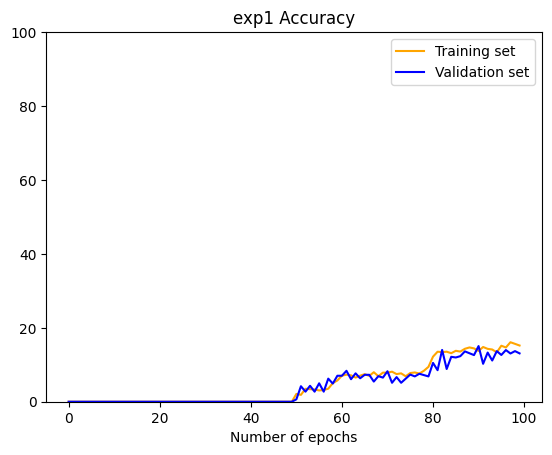

<Figure size 640x480 with 0 Axes>

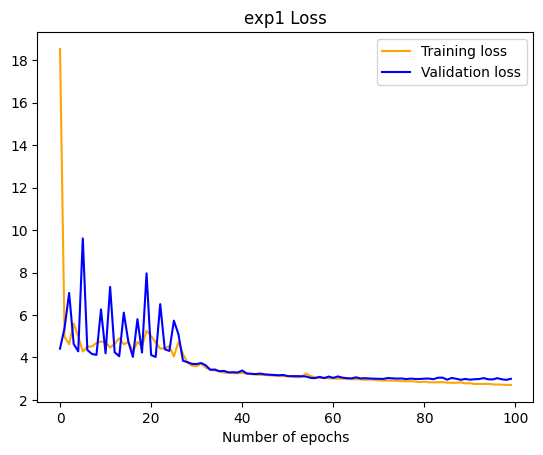

<Figure size 640x480 with 0 Axes>

In [11]:
train_loss_1, train_acc_1, eval_loss_1, eval_acc_1, name_1 = train_ocr(options_1)
train_plots(train_loss_1, train_acc_1, eval_loss_1, eval_acc_1, name_1)

#### Second experiment:

As I said before, when I first trained this model I counted any output that did not entirely consist of blanks as a success. Like for the first experiment, plots of losses and accuracies can be found at the very bottom of the output, or in the `plots` folder in the repo. 

Training...
Training epoch 0...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 0 
Average training loss: 56.9399 
Average training accuracy: 0.0685
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 0 
Validation set accuracy: 0.0 
Validation set loss: 22.494
Training epoch 1...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 1 
Average training loss: 11.9164 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 
Validation set accuracy: 0.0 
Validation set loss: 5.8881
Training epoch 2...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 2 
Average training loss: 7.7613 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 
Validation set accuracy: 0.0 
Validation set loss: 6.7631
Training epoch 3...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 3 
Average training loss: 7.3755 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3 
Validation set accuracy: 0.0 
Validation set loss: 6.4735
Training epoch 4...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 4 
Average training loss: 6.0634 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4 
Validation set accuracy: 0.0 
Validation set loss: 4.5265
Training epoch 5...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 5 
Average training loss: 7.6976 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5 
Validation set accuracy: 0.0 
Validation set loss: 4.7013
Training epoch 6...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 6 
Average training loss: 7.1298 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6 
Validation set accuracy: 0.0 
Validation set loss: 7.1057
Training epoch 7...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 7 
Average training loss: 5.5036 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7 
Validation set accuracy: 0.0 
Validation set loss: 4.4544
Training epoch 8...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 8 
Average training loss: 6.1151 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8 
Validation set accuracy: 0.0 
Validation set loss: 5.1353
Training epoch 9...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 9 
Average training loss: 7.1316 
Average training accuracy: 0.3501
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9 
Validation set accuracy: 0.0 
Validation set loss: 4.4016
Training epoch 10...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 10 
Average training loss: 5.2889 
Average training accuracy: 0.0
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10 
Validation set accuracy: 0.0 
Validation set loss: 4.6023
Training epoch 11...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 11 
Average training loss: 4.8295 
Average training accuracy: 0.137
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11 
Validation set accuracy: 0.0 
Validation set loss: 4.2682
Training epoch 12...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 12 
Average training loss: 6.4998 
Average training accuracy: 0.4966
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12 
Validation set accuracy: 0.0 
Validation set loss: 6.5534
Training epoch 13...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 13 
Average training loss: 9.6666 
Average training accuracy: 1.5653
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13 
Validation set accuracy: 0.0 
Validation set loss: 6.8257
Training epoch 14...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 14 
Average training loss: 5.3257 
Average training accuracy: 0.6164
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14 
Validation set accuracy: 0.0 
Validation set loss: 4.756
Training epoch 15...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 15 
Average training loss: 4.7346 
Average training accuracy: 1.4117
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15 
Validation set accuracy: 3.3333333333333335 
Validation set loss: 4.1543
Training epoch 16...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 16 
Average training loss: 4.07 
Average training accuracy: 1.9148
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16 
Validation set accuracy: 1.8369175627240149 
Validation set loss: 3.9256
Training epoch 17...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 17 
Average training loss: 3.6543 
Average training accuracy: 1.6172
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17 
Validation set accuracy: 2.4014336917562726 
Validation set loss: 3.6876
Training epoch 18...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 18 
Average training loss: 3.5362 
Average training accuracy: 1.4949
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18 
Validation set accuracy: 2.3655913978494625 
Validation set loss: 3.3874
Training epoch 19...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 19 
Average training loss: 3.4136 
Average training accuracy: 1.6001
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19 
Validation set accuracy: 1.8369175627240149 
Validation set loss: 3.4605
Training epoch 20...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 20 
Average training loss: 3.4042 
Average training accuracy: 1.8107
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20 
Validation set accuracy: 1.3978494623655917 
Validation set loss: 3.3489
Training epoch 21...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 21 
Average training loss: 3.383 
Average training accuracy: 1.8864
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21 
Validation set accuracy: 3.0107526881720434 
Validation set loss: 3.2946
Training epoch 22...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 22 
Average training loss: 3.3212 
Average training accuracy: 1.4555
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22 
Validation set accuracy: 1.8369175627240149 
Validation set loss: 3.2512
Training epoch 23...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 23 
Average training loss: 3.3434 
Average training accuracy: 2.0005
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23 
Validation set accuracy: 1.7562724014336921 
Validation set loss: 3.235
Training epoch 24...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 24 
Average training loss: 3.31 
Average training accuracy: 1.933
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24 
Validation set accuracy: 2.437275985663083 
Validation set loss: 3.2875
Training epoch 25...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 25 
Average training loss: 3.3004 
Average training accuracy: 1.6129
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25 
Validation set accuracy: 2.3655913978494625 
Validation set loss: 3.2344
Training epoch 26...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 26 
Average training loss: 3.2922 
Average training accuracy: 1.172
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26 
Validation set accuracy: 1.8369175627240149 
Validation set loss: 3.2584
Training epoch 27...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 27 
Average training loss: 3.3259 
Average training accuracy: 1.7099
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27 
Validation set accuracy: 1.8369175627240149 
Validation set loss: 3.2639
Training epoch 28...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 28 
Average training loss: 3.3248 
Average training accuracy: 1.5539
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28 
Validation set accuracy: 1.3978494623655917 
Validation set loss: 3.2818
Training epoch 29...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 29 
Average training loss: 3.3274 
Average training accuracy: 1.6001
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29 
Validation set accuracy: 1.1200716845878138 
Validation set loss: 3.2999
Training epoch 30...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 30 
Average training loss: 3.338 
Average training accuracy: 3.6724
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30 
Validation set accuracy: 2.3655913978494625 
Validation set loss: 3.296
Training epoch 31...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 31 
Average training loss: 3.3132 
Average training accuracy: 1.9097
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31 
Validation set accuracy: 1.720430107526882 
Validation set loss: 3.2683
Training epoch 32...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 32 
Average training loss: 3.2988 
Average training accuracy: 2.5247
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32 
Validation set accuracy: 5.277777777777778 
Validation set loss: 3.1959
Training epoch 33...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 33 
Average training loss: 3.2747 
Average training accuracy: 2.7072
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 33 
Validation set accuracy: 1.720430107526882 
Validation set loss: 3.1466
Training epoch 34...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 34 
Average training loss: 3.2795 
Average training accuracy: 2.7895
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 34 
Validation set accuracy: 1.720430107526882 
Validation set loss: 3.2157
Training epoch 35...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 35 
Average training loss: 3.2825 
Average training accuracy: 2.8196
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 35 
Validation set accuracy: 5.000000000000001 
Validation set loss: 3.2079
Training epoch 36...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 36 
Average training loss: 3.3257 
Average training accuracy: 4.47
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 36 
Validation set accuracy: 1.8369175627240149 
Validation set loss: 3.2415
Training epoch 37...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 37 
Average training loss: 3.3048 
Average training accuracy: 5.4934
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 37 
Validation set accuracy: 5.21505376344086 
Validation set loss: 3.272
Training epoch 38...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 38 
Average training loss: 3.2619 
Average training accuracy: 3.7465
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 38 
Validation set accuracy: 4.89247311827957 
Validation set loss: 3.1677
Training epoch 39...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 39 
Average training loss: 3.2403 
Average training accuracy: 4.6418
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 39 
Validation set accuracy: 1.1200716845878138 
Validation set loss: 3.1794
Training epoch 40...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 40 
Average training loss: 3.2552 
Average training accuracy: 4.0965
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 40 
Validation set accuracy: 5.707885304659499 
Validation set loss: 3.1737
Training epoch 41...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 41 
Average training loss: 3.2783 
Average training accuracy: 4.7526
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 41 
Validation set accuracy: 1.720430107526882 
Validation set loss: 3.188
Training epoch 42...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 42 
Average training loss: 3.2772 
Average training accuracy: 5.5841
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 42 
Validation set accuracy: 1.720430107526882 
Validation set loss: 3.2117
Training epoch 43...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 43 
Average training loss: 3.2805 
Average training accuracy: 5.3308
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 43 
Validation set accuracy: 4.24731182795699 
Validation set loss: 3.2007
Training epoch 44...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 44 
Average training loss: 3.2644 
Average training accuracy: 5.6661
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 44 
Validation set accuracy: 5.21505376344086 
Validation set loss: 3.1897
Training epoch 45...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 45 
Average training loss: 3.2696 
Average training accuracy: 4.7259
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 45 
Validation set accuracy: 6.56810035842294 
Validation set loss: 3.2046
Training epoch 46...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 46 
Average training loss: 3.2566 
Average training accuracy: 6.545
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 46 
Validation set accuracy: 6.102150537634409 
Validation set loss: 3.2295
Training epoch 47...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 47 
Average training loss: 3.2539 
Average training accuracy: 5.7688
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 47 
Validation set accuracy: 5.277777777777778 
Validation set loss: 3.1234
Training epoch 48...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 48 
Average training loss: 3.2304 
Average training accuracy: 6.4204
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 48 
Validation set accuracy: 7.401433691756273 
Validation set loss: 3.3167
Training epoch 49...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 49 
Average training loss: 3.281 
Average training accuracy: 6.7224
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 49 
Validation set accuracy: 7.580645161290322 
Validation set loss: 3.143
Training epoch 50...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 50 
Average training loss: 3.2758 
Average training accuracy: 5.7968
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 50 
Validation set accuracy: 5.707885304659499 
Validation set loss: 3.1701
Training epoch 51...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 51 
Average training loss: 3.2808 
Average training accuracy: 6.5681
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 51 
Validation set accuracy: 6.039426523297491 
Validation set loss: 3.3456
Training epoch 52...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 52 
Average training loss: 3.2786 
Average training accuracy: 6.6155
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 52 
Validation set accuracy: 6.048387096774194 
Validation set loss: 3.259
Training epoch 53...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 53 
Average training loss: 3.2532 
Average training accuracy: 6.802
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 53 
Validation set accuracy: 4.569892473118279 
Validation set loss: 3.2649
Training epoch 54...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 54 
Average training loss: 3.2694 
Average training accuracy: 6.5811
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 54 
Validation set accuracy: 8.037634408602152 
Validation set loss: 3.4852
Training epoch 55...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 55 
Average training loss: 3.2533 
Average training accuracy: 7.4597
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 55 
Validation set accuracy: 5.707885304659499 
Validation set loss: 3.1419
Training epoch 56...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 56 
Average training loss: 3.2459 
Average training accuracy: 6.7537
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 56 
Validation set accuracy: 6.505376344086021 
Validation set loss: 3.2242
Training epoch 57...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 57 
Average training loss: 3.2221 
Average training accuracy: 6.9359
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 57 
Validation set accuracy: 8.037634408602152 
Validation set loss: 3.2094
Training epoch 58...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 58 
Average training loss: 3.2467 
Average training accuracy: 8.0507
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 58 
Validation set accuracy: 7.500000000000001 
Validation set loss: 3.1578
Training epoch 59...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 59 
Average training loss: 3.2297 
Average training accuracy: 8.5216
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 59 
Validation set accuracy: 8.709677419354838 
Validation set loss: 3.1972
Training epoch 60...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 60 
Average training loss: 3.2178 
Average training accuracy: 7.2967
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 60 
Validation set accuracy: 7.401433691756273 
Validation set loss: 3.3555
Training epoch 61...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 61 
Average training loss: 3.2288 
Average training accuracy: 7.8824
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 61 
Validation set accuracy: 6.899641577060931 
Validation set loss: 3.1102
Training epoch 62...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 62 
Average training loss: 3.1987 
Average training accuracy: 7.5317
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 62 
Validation set accuracy: 8.109318996415771 
Validation set loss: 3.1835
Training epoch 63...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 63 
Average training loss: 3.209 
Average training accuracy: 8.6112
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 63 
Validation set accuracy: 7.858422939068101 
Validation set loss: 3.0363
Training epoch 64...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 64 
Average training loss: 3.1851 
Average training accuracy: 8.2857
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 64 
Validation set accuracy: 8.521505376344084 
Validation set loss: 3.1264
Training epoch 65...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 65 
Average training loss: 3.1392 
Average training accuracy: 10.1361
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 65 
Validation set accuracy: 9.32795698924731 
Validation set loss: 2.9889
Training epoch 66...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 66 
Average training loss: 3.1154 
Average training accuracy: 10.5874
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 66 
Validation set accuracy: 10.089605734767026 
Validation set loss: 3.16
Training epoch 67...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 67 
Average training loss: 3.1716 
Average training accuracy: 10.1617
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 67 
Validation set accuracy: 8.655913978494626 
Validation set loss: 3.1539
Training epoch 68...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 68 
Average training loss: 3.1241 
Average training accuracy: 11.3634
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 68 
Validation set accuracy: 11.657706093189962 
Validation set loss: 3.1351
Training epoch 69...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 69 
Average training loss: 3.1174 
Average training accuracy: 12.566
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 69 
Validation set accuracy: 13.808243727598569 
Validation set loss: 3.1738
Training epoch 70...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 70 
Average training loss: 3.0798 
Average training accuracy: 13.0918
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 70 
Validation set accuracy: 14.18458781362007 
Validation set loss: 3.148
Training epoch 71...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 71 
Average training loss: 3.0429 
Average training accuracy: 13.3072
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 71 
Validation set accuracy: 12.777777777777779 
Validation set loss: 3.0941
Training epoch 72...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 72 
Average training loss: 3.0298 
Average training accuracy: 15.1836
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 72 
Validation set accuracy: 13.933691756272403 
Validation set loss: 3.004
Training epoch 73...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 73 
Average training loss: 2.9835 
Average training accuracy: 14.5803
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 73 
Validation set accuracy: 13.870967741935484 
Validation set loss: 3.044
Training epoch 74...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 74 
Average training loss: 2.9786 
Average training accuracy: 15.0557
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 74 
Validation set accuracy: 14.49820788530466 
Validation set loss: 3.1049
Training epoch 75...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 75 
Average training loss: 2.9697 
Average training accuracy: 15.1192
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 75 
Validation set accuracy: 15.985663082437275 
Validation set loss: 3.0775
Training epoch 76...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 76 
Average training loss: 3.017 
Average training accuracy: 17.2779
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 76 
Validation set accuracy: 11.146953405017921 
Validation set loss: 3.1377
Training epoch 77...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 77 
Average training loss: 3.0041 
Average training accuracy: 16.051
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 77 
Validation set accuracy: 12.956989247311828 
Validation set loss: 2.9705
Training epoch 78...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 78 
Average training loss: 2.97 
Average training accuracy: 16.3606
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 78 
Validation set accuracy: 16.03046594982079 
Validation set loss: 3.0739
Training epoch 79...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 79 
Average training loss: 2.9368 
Average training accuracy: 15.0607
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 79 
Validation set accuracy: 17.53584229390681 
Validation set loss: 3.0477
Training epoch 80...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 80 
Average training loss: 2.9512 
Average training accuracy: 15.7165
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 80 
Validation set accuracy: 11.353046594982079 
Validation set loss: 3.0752
Training epoch 81...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 81 
Average training loss: 2.9266 
Average training accuracy: 16.6966
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 81 
Validation set accuracy: 15.824372759856626 
Validation set loss: 2.9781
Training epoch 82...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 82 
Average training loss: 2.913 
Average training accuracy: 17.8878
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 82 
Validation set accuracy: 14.829749103942651 
Validation set loss: 2.9805
Training epoch 83...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 83 
Average training loss: 2.9923 
Average training accuracy: 17.7617
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 83 
Validation set accuracy: 14.274193548387093 
Validation set loss: 2.8707
Training epoch 84...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 84 
Average training loss: 2.8962 
Average training accuracy: 16.9576
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 84 
Validation set accuracy: 15.887096774193548 
Validation set loss: 2.9565
Training epoch 85...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 85 
Average training loss: 2.9373 
Average training accuracy: 18.5358
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 85 
Validation set accuracy: 13.637992831541217 
Validation set loss: 3.0144
Training epoch 86...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 86 
Average training loss: 2.9708 
Average training accuracy: 15.9396
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 86 
Validation set accuracy: 11.729390681003583 
Validation set loss: 3.0481
Training epoch 87...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 87 
Average training loss: 2.9766 
Average training accuracy: 16.3872
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 87 
Validation set accuracy: 14.560931899641574 
Validation set loss: 2.8787
Training epoch 88...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 88 
Average training loss: 2.9213 
Average training accuracy: 16.0805
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 88 
Validation set accuracy: 17.571684587813618 
Validation set loss: 2.842
Training epoch 89...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 89 
Average training loss: 2.9199 
Average training accuracy: 16.9357
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 89 
Validation set accuracy: 12.948028673835127 
Validation set loss: 3.0945
Training epoch 90...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 90 
Average training loss: 2.9304 
Average training accuracy: 17.3631
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 90 
Validation set accuracy: 15.080645161290319 
Validation set loss: 2.8868
Training epoch 91...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 91 
Average training loss: 2.949 
Average training accuracy: 16.2634
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 91 
Validation set accuracy: 16.980286738351257 
Validation set loss: 2.9723
Training epoch 92...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 92 
Average training loss: 2.927 
Average training accuracy: 14.7598
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 92 
Validation set accuracy: 14.525089605734768 
Validation set loss: 2.919
Training epoch 93...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 93 
Average training loss: 2.9272 
Average training accuracy: 15.4708
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 93 
Validation set accuracy: 12.338709677419354 
Validation set loss: 2.9139
Training epoch 94...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 94 
Average training loss: 2.8723 
Average training accuracy: 16.3724
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 94 
Validation set accuracy: 13.234767025089603 
Validation set loss: 2.9485
Training epoch 95...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 95 
Average training loss: 2.8767 
Average training accuracy: 15.2207
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 95 
Validation set accuracy: 14.193548387096774 
Validation set loss: 2.9456
Training epoch 96...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 96 
Average training loss: 2.9498 
Average training accuracy: 14.6692
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 96 
Validation set accuracy: 15.654121863799284 
Validation set loss: 2.8911
Training epoch 97...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 97 
Average training loss: 2.889 
Average training accuracy: 17.5255
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 97 
Validation set accuracy: 12.464157706093193 
Validation set loss: 3.1407
Training epoch 98...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 98 
Average training loss: 2.8917 
Average training accuracy: 15.8521
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 98 
Validation set accuracy: 15.483870967741936 
Validation set loss: 3.008
Training epoch 99...


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 99 
Average training loss: 2.9346 
Average training accuracy: 15.3194
Evaluating...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 99 
Validation set accuracy: 12.284946236559142 
Validation set loss: 3.1236


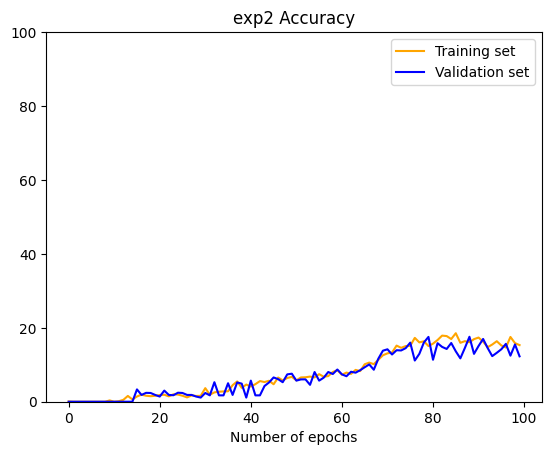

<Figure size 640x480 with 0 Axes>

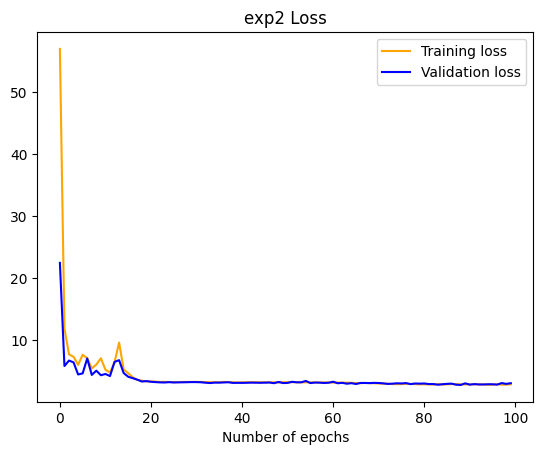

<Figure size 640x480 with 0 Axes>

In [16]:
train_loss_2, train_acc_2, eval_loss_2, eval_acc_2, name_2 = train_ocr(options_2)
train_plots(train_loss_2, train_acc_2, eval_loss_2, eval_acc_2, name_2)

### Evaluation and discussion
To see where the models went wrong, especially during my first short test-runs, I wanted to see if the characters my models predicted were simply the ones with the highest frequency in the original dataset. My plots of this information can be seen below. I also borrowed some of the code from the original tutorial to display some images, their gold labels and the model's predictions.

In [13]:
# This function is borrowed from the tutorial but modified:

def get_accuracy(options):
    loader = DataLoader(options['test_data'],
                batch_size=options['batch_size'],
                collate_fn=MyCollator())
    device = options['device']
    model = options['model'].to(device)
    model.eval()
    converter = OCRLabelConverter(options['alphabet'])
    labels, predictions, images = [], [], []
    print('Testing model...')
    with torch.no_grad():
        for iteration, batch in enumerate(tqdm(loader)):
            input, targets = batch['img'].to(device), batch['label']
            images.extend(input.squeeze().detach())
            labels.extend(targets)
            targets, lengths = converter.encode(targets)
            logits = model(input).transpose(1, 0)
            logits = torch.nn.functional.log_softmax(logits, 2)
            logits = logits.contiguous().cpu()
            T, B, H = logits.size()
            pred_sizes = torch.LongTensor([T for i in range(B)])
            probs, pos = logits.max(2)
            pos = pos.transpose(1, 0).contiguous().view(-1)
            sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
            predictions.extend(sim_preds)
        
#   make_grid(images[:10], nrow=2)
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    #pairs = list(zip(images, predictions))
    indices = np.random.permutation(len(images))
    for i in range(1, columns*rows +1):
        img = images[indices[i]]
        img = (img - img.min())/(img.max() - img.min())
        img = np.array(img.cpu() * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title('True label: '+labels[indices[i]]+'\nPrediction: '+predictions[indices[i]], fontsize=8)
        plt.axis('off')
        plt.imshow(img)
    plt.show()
    acc = np.mean((list(map(char_accuracy, list(zip(predictions, labels))))))
    return acc, predictions


In [17]:
# This is my own code:

def plot_occurrance(count_file, model_predictions):
    """
    Given a file containing the counts of character occurrances in the training data
    and a list of model predictions, plots the relative frequency of each character 
    (in percent) in the original data and in the model's predictions.
    """
    chars = ['']
    file_counts = [0]
    with open(count_file) as file:
        for line in file:
            char, count = line.split()
            chars.append(char)
            file_counts.append(int(count))
    predicted_chars = []
    for pred in model_predictions:
        if pred == '':
            predicted_chars.append(pred)
        else:
            predicted_chars.extend(list(pred))
    counter = Counter(predicted_chars)
    pred_counts = [counter[chars[i]] for i in range(len(chars))]

    file_percent = [(x/sum(file_counts))*100 for x in file_counts]
    pred_percent = [(x/sum(pred_counts))*100 for x in pred_counts]
    chars[0] = "''"

    # Plot occurrance:
    x = np.arange(len(chars))  # the label locations
    width = 0.4  # the width of the bars
    
    fig, ax = plt.subplots(layout='constrained')

    rects = ax.bar(x, file_percent, width, label='In data')
    rects = ax.bar(x + width, pred_percent, width, label='In model predictions')
    
    ax.set_ylabel('Character occurrance in percent')
    ax.set_title('Character occurrance')
    ax.set_xticks(x + width, chars)
    ax.legend(loc='upper left', ncols=2)
    
    plt.show()


In [18]:
# This code is more or less borrowed from the tutorial,
# but I made some small changes and put it in a function
# for reusability:

def test_model(options):
    resume_file = options['checkpoint_dir']+options['experiment_name']+'_best_model.pt'
    model = options['model']
    if os.path.isfile(resume_file):
        print('Loading model %s'%resume_file)
        checkpoint = torch.load(resume_file)
        model.load_state_dict(checkpoint)
        options['model'] = model
        acc, predictions = get_accuracy(options)
        print("Character Accuracy: %.2f"%(acc))
        plot_occurrance('../data/count.txt', predictions)
    else:
        print(f"=> no checkpoint found at '{resume_file}'")
        print('Exiting')

#### Testing model 1:

Loading model ../checkpoints/exp1_best_model.pt
Testing model...


  0%|          | 0/8 [00:00<?, ?it/s]

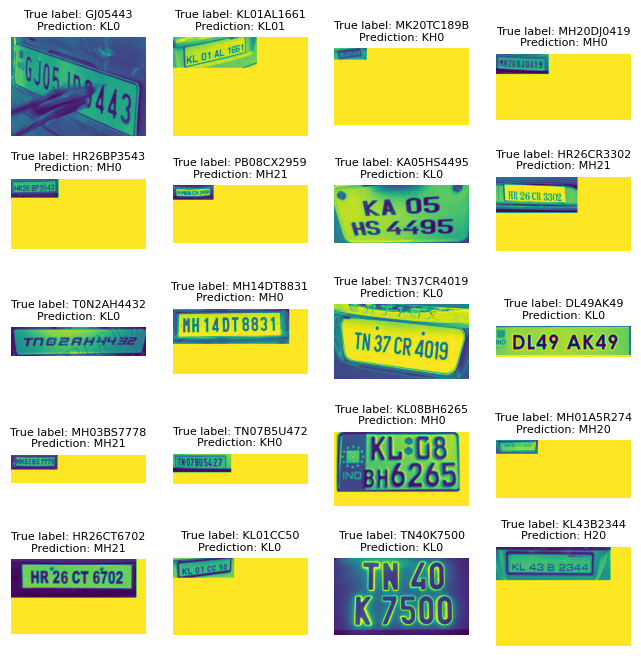

Character Accuracy: 14.95


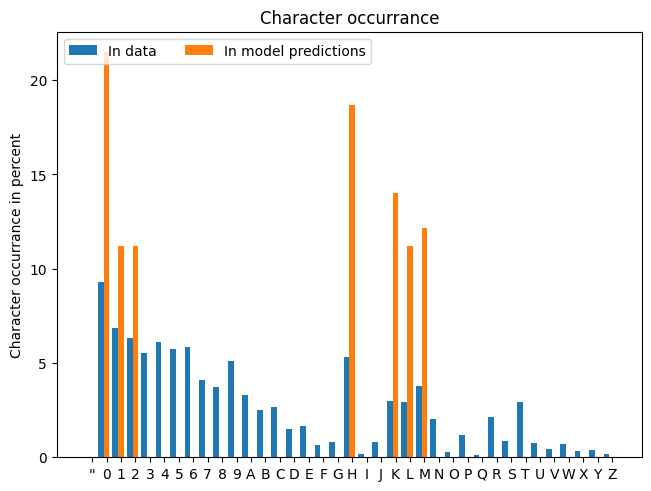

In [19]:
test_model(options_1)

#### Testing model 2:

Loading model ../checkpoints/exp2_best_model.pt
Testing model...


  0%|          | 0/16 [00:00<?, ?it/s]

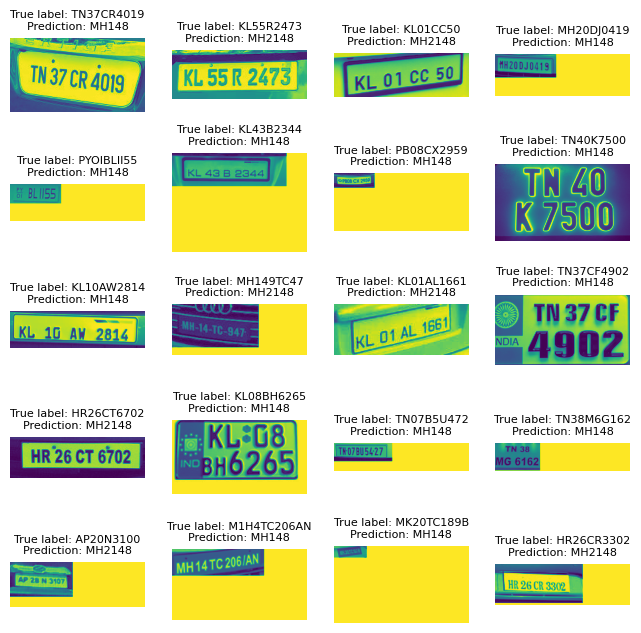

Character Accuracy: 15.99


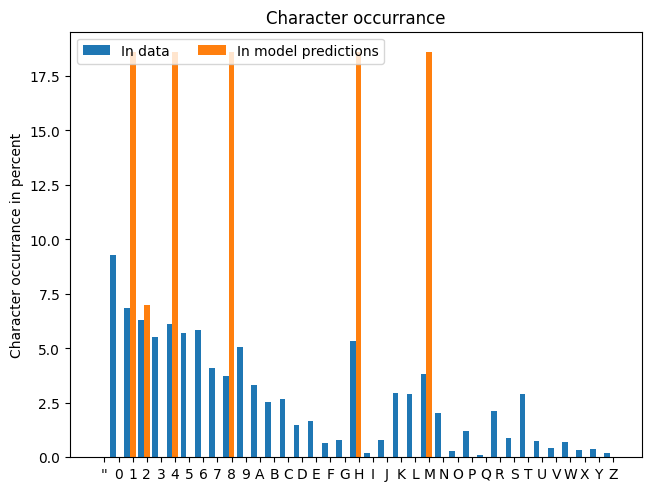

In [21]:
test_model(options_2)

### Discussion

From what I can see in these plots, the most predicted characters are not necessarily the ones with the highest frequency in the original dataset. Even so, when looking at examples of model output, it does seem like both models find some sort of local minima and stay there. The first model, for example, tends to predict very short labels, and the sequence KLO seems especially frequent. The second model predicts longer sequences, but they all seem to be either MH148 or MH2148. On the whole, the predictions do not seem to have very much to do with the actual sequences in the labels. It reminds me of problems I have had before, for example in binary classification on an unbalanced dataset, where the model simply resorted to predicting positive every time since that was the most frequent label. In that case, I could solve it by weighting the BCE loss function by the distribution of the classes in the training data, so that false positives were punished more severely than false negatives. I think that is an option for some other loss functions as well, but I could not find anything like that for the CTC loss function. I guess the solution might just be longer training times (preferrably on a bigger dataset), and possibly starting with a high learning rate and gradually decreasing it as the accuracy starts to improve. 